In [58]:
import yfinance as yf
import pandas as pd
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import CLA
import matplotlib.pyplot as plt
import datetime
from datetime import date
import seaborn as sns
import numpy as np

#rio = yf.Ticker("RIO")
#bhp=yf.Ticker('BHP')
#hist = rio.history(period="5y")
#print(len(hist))



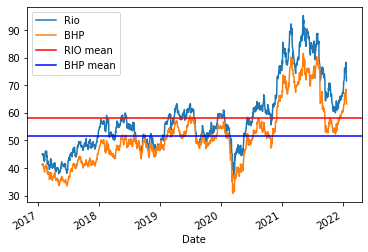

Correlation Open               0.977261
High               0.977167
Low                0.977108
Close              0.977223
Adj Close          0.973965
Volume             0.539194
open_pct_change    0.873763
dtype: float64


In [42]:
rio_df=pd.read_csv('RIO.csv',parse_dates=['Date'],index_col=0)
bhp_df=pd.read_csv('BHP.csv',parse_dates=['Date'],index_col=0)
filter=rio_df.index>'1/1/2017'
rio_df=rio_df[filter]
rio_df['Open'].plot(label='Rio')
filter=bhp_df.index>'1/1/2017'
bhp_df=bhp_df[filter]
bhp_df['Open'].plot(label='BHP')

rio_df['open_pct_change']=rio_df['Open'].pct_change()
bhp_df['open_pct_change']=bhp_df['Open'].pct_change()

mean = rio_df['Open'].mean()
plt.axhline(y=mean, color='r', linestyle='-',label='RIO mean')

mean = bhp_df['Open'].mean()
plt.axhline(y=mean, color='b', linestyle='-',label='BHP mean')
plt.legend()
plt.show()
print("Correlation",rio_df.corrwith(bhp_df,axis=0))

In [43]:
portfolio_returns_rio=rio_df.resample('Q')['Open'].sum().reset_index()
portfolio_returns_bhp=bhp_df.resample('Q')['Open'].sum().reset_index()
#portfolio_returns_rio.plot()
#portfolio_returns_bhp.plot()

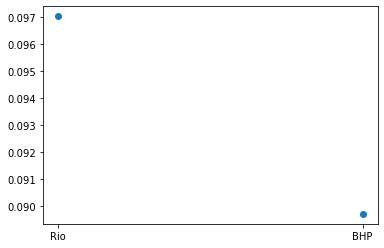

In [44]:
prices=rio_df.merge(bhp_df, on="Date",suffixes=['_Rio','_BHP'])
#print(prices)
prices=pd.DataFrame({'Date':prices.index,'Rio':prices['Open_Rio'],'BHP':prices['Open_BHP']})
prices.set_index("Date",inplace=True)
#print(prices)

mean_returns=mean_historical_return(prices,frequency=252)

# Plot the annualized average historical return
plt.plot(mean_returns, linestyle = 'None', marker = 'o')
plt.show()

<AxesSubplot:xlabel='Date'>

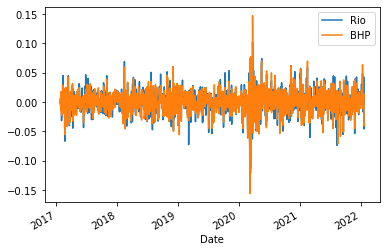

In [45]:
chg=prices.pct_change()
chg.plot()

In [46]:
cs = CovarianceShrinkage(prices)
sample_cov = prices.pct_change().cov() * 252
e_cov = cs.ledoit_wolf()

print("Sample Covariance Matrix\n", sample_cov, "\n")
print("Efficient Covariance Matrix\n", e_cov, "\n")

Sample Covariance Matrix
           Rio       BHP
Rio  0.103667  0.089134
BHP  0.089134  0.100382 

Efficient Covariance Matrix
           Rio       BHP
Rio  0.103565  0.087972
BHP  0.087972  0.100322 



Constrained Line Algorithm (CLA) class: generates the entire efficient frontier
1. requires covariance matrix of returns
2. requires proxy for expected future returns: mean historical returns
The expected return is the profit or loss that an investor anticipates on an investment that has known historical rates of return (RoR).


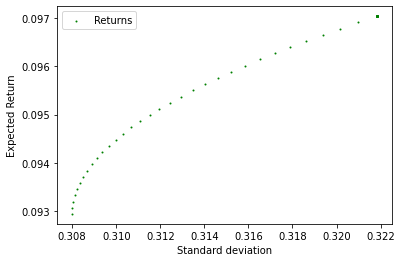

the expected returns is 10%


In [47]:
print("Constrained Line Algorithm (CLA) class: generates the entire efficient frontier")
print("1. requires covariance matrix of returns")
print("2. requires proxy for expected future returns: mean historical returns")
print("The expected return is the profit or loss that an investor anticipates on an investment that has known historical rates of return (RoR).")
    
cla=CLA(mean_returns,e_cov)

(ret, vol, weights) = cla.efficient_frontier()

# Add the frontier to the plot showing the 'before' and 'after' frontiers
plt.scatter(vol, ret, s = 4, c = 'g', marker = '.', label = 'Returns')
plt.xlabel('Standard deviation')
plt.ylabel('Expected Return')
plt.legend()
plt.show()

print("the expected returns is 10%")

2017-02-01 00:00:00 45.110001 2
2017-02-13 00:00:00 46.080002 2
2017-03-02 00:00:00 42.490002 2
2017-03-08 00:00:00 41.029999 2
2017-03-13 00:00:00 40.790001 2
2017-03-16 00:00:00 43.400002 2
2017-03-29 00:00:00 40.560001 2
2017-04-04 00:00:00 41.049999 2
2017-04-11 00:00:00 41.860001 2
2017-04-24 00:00:00 40.080002 2
2017-04-28 00:00:00 40.110001 2
2017-05-10 00:00:00 39.02 2
2017-05-16 00:00:00 39.939999 2
2017-05-22 00:00:00 42.209999 2
2017-06-26 00:00:00 39.5 2
2017-06-29 00:00:00 42.169998 2
2017-07-12 00:00:00 44.73 2
2017-07-17 00:00:00 45.439999 2
2017-07-26 00:00:00 46.07 2
2017-08-04 00:00:00 47.07 2
2017-08-22 00:00:00 45.98 2
2017-08-31 00:00:00 48.84 2
2017-09-19 00:00:00 47.990002 2
2017-10-02 00:00:00 47.439999 2
2017-10-09 00:00:00 49.150002 2
2017-10-16 00:00:00 50.669998 2
2017-11-06 00:00:00 50.040001 2
2017-11-22 00:00:00 48.740002 2
2017-12-11 00:00:00 47.900002 2
2017-12-14 00:00:00 48.77 2
2017-12-21 00:00:00 50.970001 2
2017-12-28 00:00:00 52.630001 2
2018-01-0

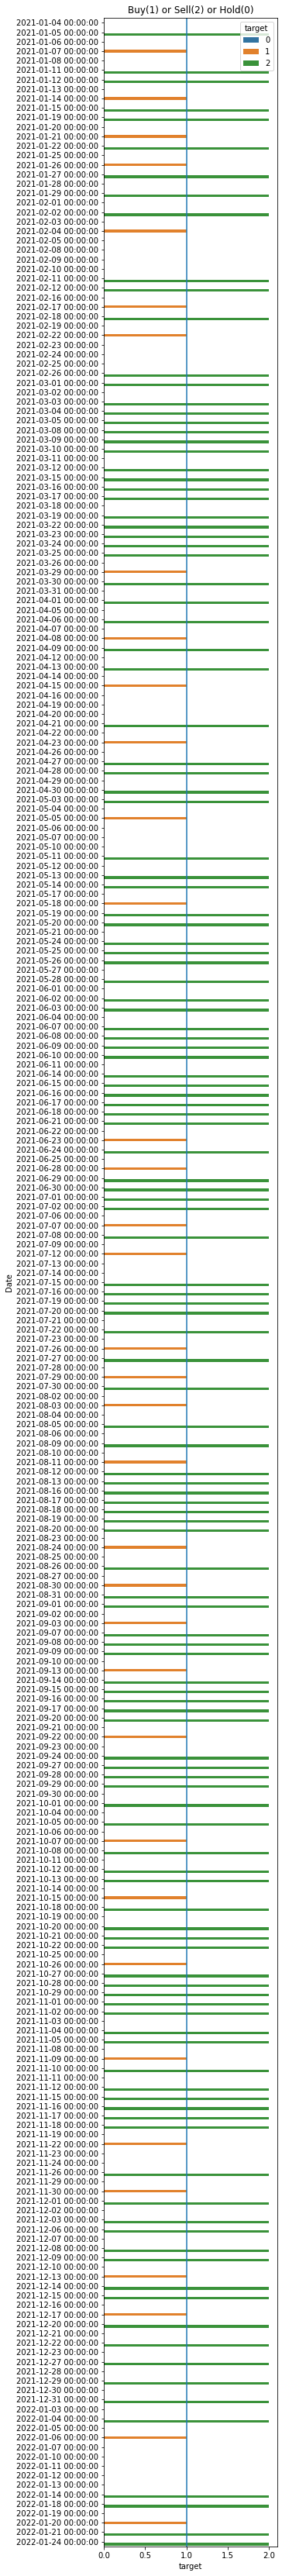

In [56]:
rio_df["buy_count"]=0

def SetOpenPositiveCount(df):
    df["open_pct_positive_count"]=0
    for index in range(len(df)):
    #print(df.iloc[index])
        count=0
        for index2 in (range(index,0,-1)):
            #print(df.iloc[index2]["open_pct_change"])
            if df.iloc[index2]["open_pct_change"]>0:
                count=count+1
                #print("found",count)
            else:
                break
        #print("count",count)
        df.iloc[index, df.columns.get_loc('open_pct_positive_count')]=count
    return df

def SetPctChange(df):
    for index in range(len(df)):
        count=0
        for index2 in (range(index,0,-1)):
            if df.iloc[index2]["open_pct_change"]>0:
                count=count+1
            else:
                break
        df.iloc[index, df.columns.get_loc('buy_count')]=count
        
    df['action']=[ 'Sell' if x['buy_count']==0 else 'Buy' if x['buy_count']==2 else 'Hold' if x['buy_count'] > 2 else 'No Action' for key,x in df.iterrows()]
                
    df["target"]=0
    for index in range(len(df)):
        action=df.iloc[index]["action"]
        if (action=='Buy'):
             df.iloc[index, df.columns.get_loc('target')]=1
        elif (action=='Sell'):
             df.iloc[index, df.columns.get_loc('target')]=2
        
    buy_list=df[df["target"]==1]
    for index,item in buy_list.iterrows():
        print(index,item["Open"],item["open_pct_positive_count"])
    
    today = datetime.datetime.today()
    filter=df.index.year >=  today.year-1
    results=df[filter]

    return results

rio_df=SetOpenPositiveCount(rio_df)
results=SetPctChange(rio_df)
    

plt.figure(figsize=(4,60))
sns.barplot(data=results, x='target', y=results.index, hue='target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('Rio Buy(1) or Sell(2) or Hold(0)')
plt.show()    

Buy 333
Sell 163
Hold 74


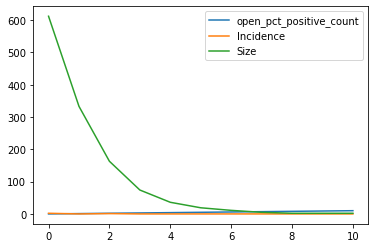

I  want low numbers of buy, high numbers of hold, and low numbers of sell.  Rio is very volatile


In [63]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

# Calculate the predictor insight graph table for the variable gender
pig_table = create_pig_table(rio_df, "target", "open_pct_positive_count")
#print(pig_table)
print("Buy",len(rio_df[rio_df['open_pct_positive_count']==1]))
print("Sell",len(rio_df[rio_df['open_pct_positive_count']==2]))
print("Hold",len(rio_df[rio_df['open_pct_positive_count']==3]))

pig_table.plot()
plt.show()

print("I  want low numbers of buy, high numbers of hold, and low numbers of sell.  Rio is very volatile.  This pattern could change in the near future")

2017-02-01 00:00:00 41.5 2
2017-02-13 00:00:00 40.529999 2
2017-02-16 00:00:00 41.07 2
2017-03-02 00:00:00 38.650002 2
2017-03-13 00:00:00 36.389999 2
2017-03-16 00:00:00 38.290001 2
2017-03-29 00:00:00 36.43 2
2017-04-04 00:00:00 36.639999 2
2017-04-11 00:00:00 38.439999 2
2017-04-24 00:00:00 36.349998 2
2017-05-10 00:00:00 34.98 2
2017-05-16 00:00:00 35.990002 2
2017-05-22 00:00:00 36.889999 2
2017-06-12 00:00:00 35.380001 2
2017-06-19 00:00:00 34.84 2
2017-06-26 00:00:00 34.32 2
2017-07-05 00:00:00 37.02 2
2017-07-12 00:00:00 38.470001 2
2017-07-26 00:00:00 40.450001 2
2017-08-01 00:00:00 41.619999 2
2017-08-04 00:00:00 40.950001 2
2017-08-17 00:00:00 40.860001 2
2017-08-22 00:00:00 41.52 2
2017-08-25 00:00:00 42.59 2
2017-08-31 00:00:00 43.450001 2
2017-09-20 00:00:00 42.400002 2
2017-10-02 00:00:00 40.779999 2
2017-10-16 00:00:00 42.990002 2
2017-10-31 00:00:00 40.830002 2
2017-11-06 00:00:00 43.240002 2
2017-11-22 00:00:00 42.25 2
2017-12-01 00:00:00 41.669998 2
2017-12-11 00:00:

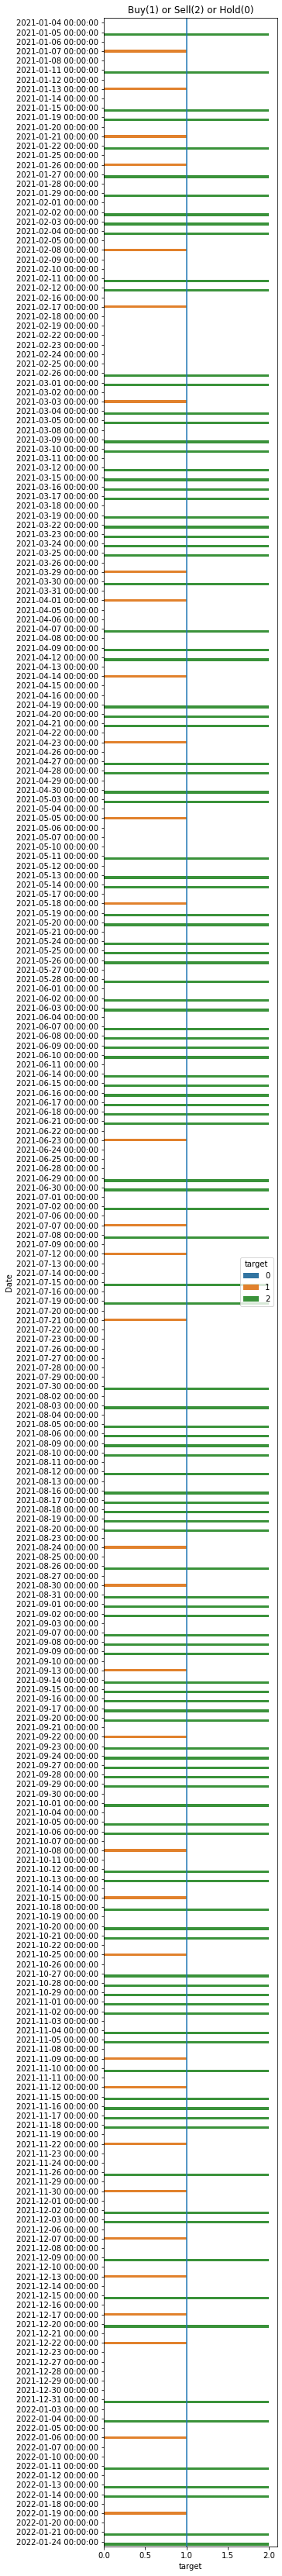

In [65]:
bhp_df["buy_count"]=0
bhp_df=SetOpenPositiveCount(bhp_df)
results=SetPctChange(bhp_df)
    

plt.figure(figsize=(4,60))
sns.barplot(data=results, x='target', y=results.index, hue='target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('Buy(1) or Sell(2) or Hold(0)')
plt.show()    

Buy 322
Sell 160
Hold 84


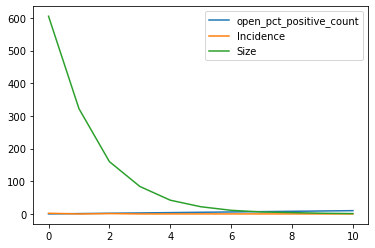

In [66]:
pig_table = create_pig_table(bhp_df, "target", "open_pct_positive_count")
#print(pig_table)
print("Buy",len(rio_df[bhp_df['open_pct_positive_count']==1]))
print("Sell",len(rio_df[bhp_df['open_pct_positive_count']==2]))
print("Hold",len(rio_df[bhp_df['open_pct_positive_count']==3]))

pig_table.plot()
plt.show()